In [2]:
import pandas as pd
from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
stop=stopwords.words('english')
import spacy
import re
nlp=spacy.load('en_core_web_sm')


/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load and preprocess the data

In [3]:
data=pd.read_excel('/Volumes/T7/UIUC/Summer_2023/IMLS/STEM programming coding - Goals Activities Outcomes - SHARE.xlsx')#, encoding='latin-1')

In [4]:
data.columns

Index(['New number', 'Project code', 'Project goals',
       'Project activities/outcomes',
       'Grant start year (when was this grant awarded)'],
      dtype='object')

In [5]:
data=data.fillna('') # fill empty cells with empty string
data['goal']=data['Project goals']+data['Project activities/outcomes']
data['goal']=data['goal'].str.lower()

In [6]:
def lemmatization(dataframe):
    dataframe['goal_lower'] = dataframe['goal'].astype(str).str.lower()
    dataframe['stopword'] = dataframe['goal_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')
    dataframe['lemma'] = dataframe['punct'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['lemma_length'] = dataframe['lemma'].apply(lambda x: ' '.join([s for s in x.split() if s is not None and len(s) >= 3 and not re.match(r'^\d+$', s)]))
    dataframe['lemma_stop'] = dataframe['lemma_length'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['final'] = dataframe['lemma_stop'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['token'] = dataframe['final'].apply(word_tokenize)
    return dataframe

<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:4: DeprecationWarning: invalid escape sequence '\w'
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1405/4137522434.py:4: DeprecationWarning: invalid escape sequence '\w'
  dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')


In [7]:
data=lemmatization(data)

LDA

In [8]:
id2word = corpora.Dictionary(data['token'])
texts = data['token']
corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [10]:
pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0,
  '0.048*"face" + 0.025*"asset" + 0.010*"employee" + 0.007*"dade" + '
  '0.005*"jail" + 0.005*"reopen" + 0.005*"safe" + 0.005*"equity" + 0.005*"gap" '
  '+ 0.005*"respond"'),
 (1,
  '0.023*"community" + 0.023*"project" + 0.021*"library" + 0.020*"program" + '
  '0.018*"stem" + 0.018*"science" + 0.012*"learn" + 0.012*"teen" + '
  '0.012*"youth" + 0.011*"digital"'),
 (2,
  '0.026*"learn" + 0.023*"oneida" + 0.013*"collection" + 0.013*"century" + '
  '0.013*"21st" + 0.013*"awareness" + 0.013*"laboratory" + 0.012*"tribe" + '
  '0.012*"time" + 0.011*"program"'),
 (3,
  '0.042*"library" + 0.024*"space" + 0.021*"maker" + 0.016*"innovation" + '
  '0.015*"introduce" + 0.011*"people" + 0.010*"equity" + 0.010*"need" + '
  '0.010*"connecticut" + 0.009*"culture"'),
 (4,
  '0.017*"library" + 0.016*"culture" + 0.016*"quality" + 0.014*"main" + '
  '0.014*"office" + 0.013*"health" + 0.013*"physical" + 0.013*"jemez" + '
  '0.013*"pueblo" + 0.013*"child"'),
 (5,
  '0.032*"library" + 0.026*"school" + 0

In [11]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.185585  0.000852       1        1  34.106811
6      0.172823  0.054837       2        1  19.837090
9      0.129495  0.057838       3        1  18.495071
8      0.110758 -0.191886       4        1  10.152973
5     -0.009907  0.090269       5        1   6.398259
3     -0.131337 -0.053237       6        1   3.808202
4     -0.118963  0.013086       7        1   2.670254
2     -0.074297  0.057642       8        1   2.314073
7     -0.126993 -0.016034       9        1   1.530423
0     -0.137164 -0.013366      10        1   0.686846, topic_info=         Term        Freq       Total Category  logprob  loglift
115   library  211.000000  211.000000  Default  30.0000  30.0000
55      learn  103.000000  103.000000  Default  29.0000  29.0000
103   digital   72.000000   72.000000  Default  28.0000  28.0000
21     school  108.000000  108.000000  Default  27.0000  27.0000
19    program  147.000000  147.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
103   digital    0.216601   72.548340  Topic10  -5.7278  -0.8331
782    indian    0.186929    4.709664  Topic10  -5.8752   1.7542
1235    basic    0.172150    1.486285  Topic10  -5.9575   2.8251
367    reduce    0.172143    1.690567  Topic10  -5.9576   2.6963
819   fulfill    0.172140    1.244073  Topic10  -5.9576   3.0030

[590 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
171       1  0.691394     21st
171       8  0.230465     21st
519       4  0.836446        @
773       7  0.601286  aaniiih
665       1  0.882359  academy
...     ...       ...      ...
469       1  0.601769    youth
469       2  0.142524    youth
469       3  0.221704    youth
469       8  0.031672    youth
1347      1  0.959714      zoo

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 10, 9, 6, 4, 5, 3, 8, 1])

Q. What is the dominant topic for each document?

In [12]:
document_topics = lda_model.get_document_topics(corpus)
dominant=[]
for i, doc_topics in enumerate(document_topics):
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant.append(sorted_topics[0][0])

In [13]:
data['dominant_topic']=dominant

Q. What is the topic distribution for each document?

In [14]:
topic_dist_list=[]
for i, doc_topics in enumerate(document_topics):
    topic_dist={}
    for topic, prob in doc_topics:
        topic_dist[topic]=prob
    topic_dist_list.append(topic_dist)
data['topic_dist']=topic_dist_list

Visualize the topic distribution

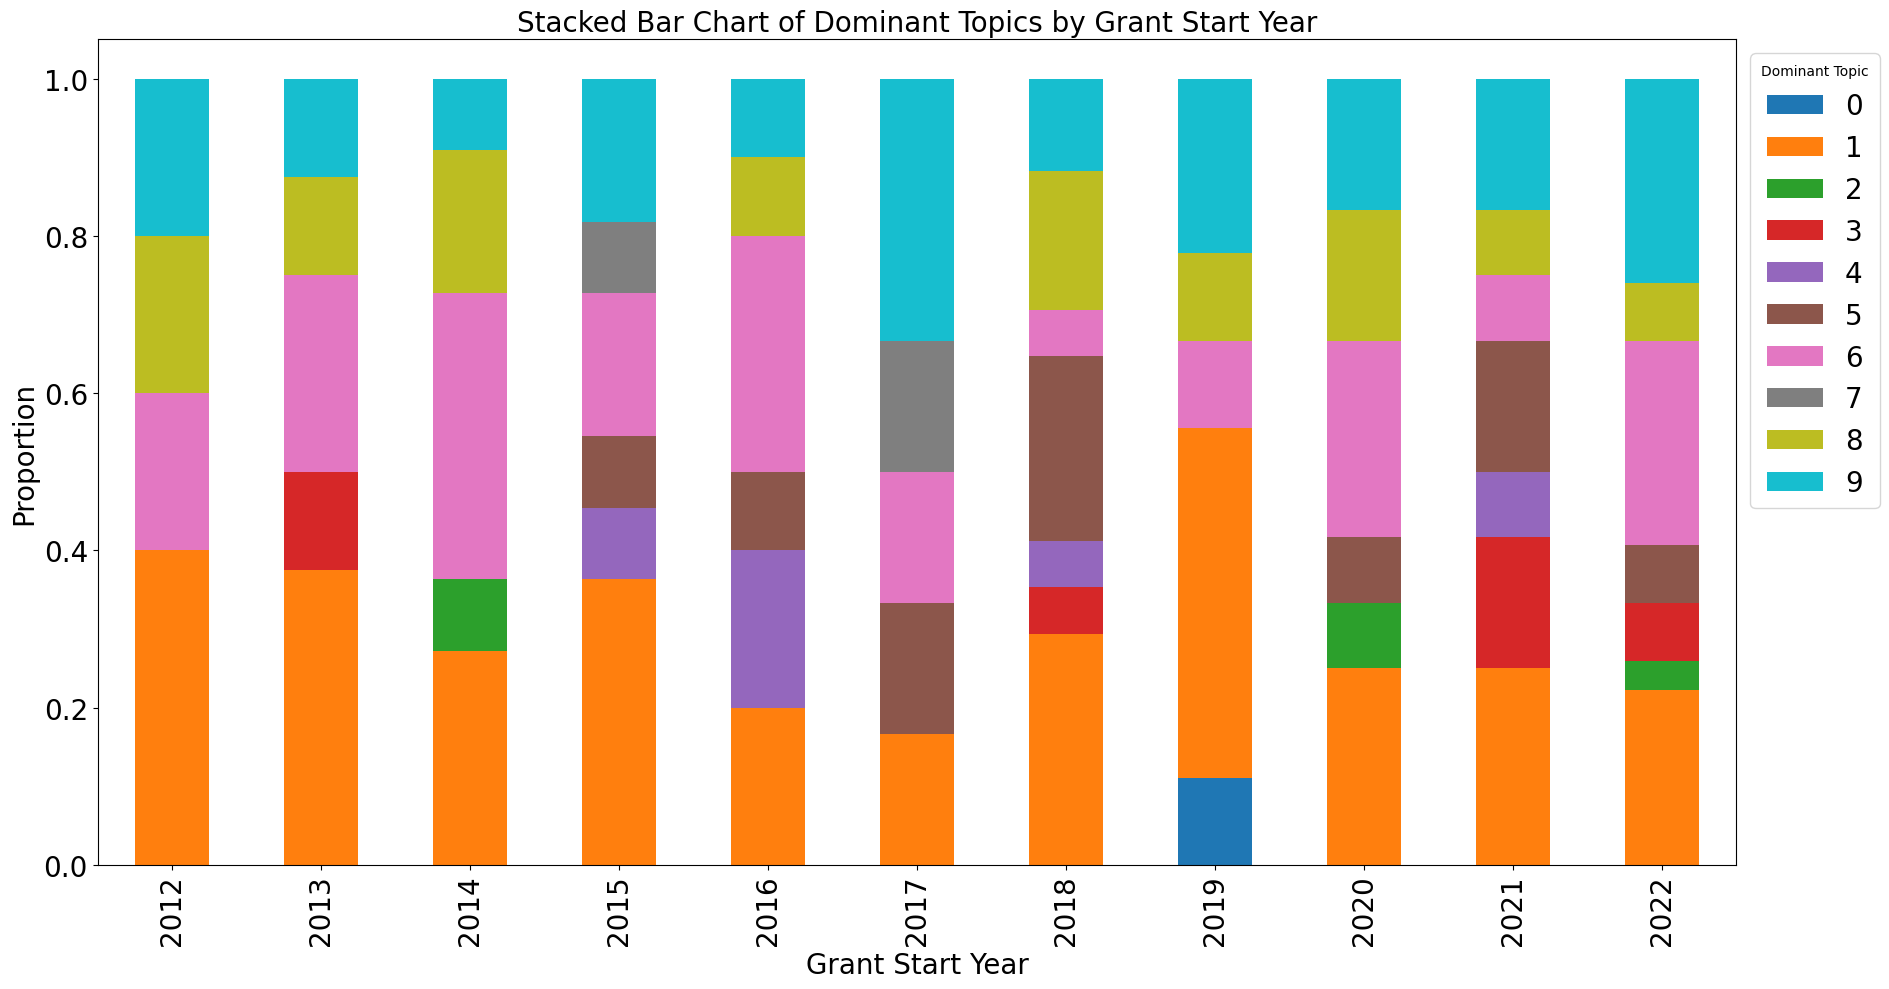

In [53]:
grouped_data = data.groupby(['Grant start year (when was this grant awarded)', 'dominant_topic']).size()
reshaped_data = grouped_data.unstack(level='dominant_topic')
normalized_data = reshaped_data.div(reshaped_data.sum(axis=1), axis=0)

ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 10), fontsize=20)

plt.xlabel('Grant Start Year', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

legend = ax.legend(title='Dominant Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

plt.title('Stacked Bar Chart of Dominant Topics by Grant Start Year', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


In [55]:
data.to_csv('data/lda.csv')